In [1]:
!nvidia-smi

Tue Jul 15 20:18:51 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off | 00000000:07:00.0 Off |                    0 |
| N/A   31C    P0              61W / 400W |      3MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [3]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

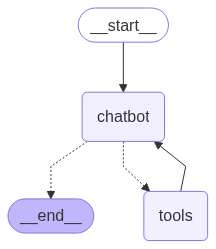

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
graph.invoke({"messages": [{"role": "user", "content": "What is the capital of France?"}]})
graph.invoke(State(messages=["What do you know about LangGraph?"]))

{'messages': [HumanMessage(content='What do you know about LangGraph?', additional_kwargs={}, response_metadata={}, id='b8ac9bfc-562d-496a-9131-0dbad64cd115'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2zbRsUaPmzNYQWUat9nK66fk', 'function': {'arguments': '{"query":"LangGraph","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 798, 'total_tokens': 820, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-BtY0F5LCFS9TNXlw9shHrrOD4Wlcj', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d89f410a-cf6b-47c1-ad36-055115fd986d-0', tool_calls=[{'name': 'tavily_search', 'args': {

### tool 정의

In [ ]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=5)
tools = [tool]
# tool.invoke("What's a 'node' in LangGraph?")

### Graph 정의

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

### Create a function to run the tools

In [ ]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

### Define conditional_edges

In [ ]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Ask the bot questions

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break